In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
train_dir = "/content/drive/MyDrive/Defungi Classification/data/train"
test_dir = "/content/drive/MyDrive/Defungi Classification/data/test"

# data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.9, 1.1)
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True
  )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle=False
  )

# weighted train
labels = train_data.classes
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weight))
print("Class weights : ", class_weight_dict)

base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
gap = GlobalAveragePooling2D()(x)
gmp = GlobalMaxPooling2D()(x)
x = Concatenate()([gap, gmp])
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early   = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)


model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history1 = model.fit(
    train_data, validation_data=test_data, epochs=5,
    class_weight=class_weight_dict, callbacks=[plateau]
)

base_model.trainable = True
unfreeze = False
for layer in base_model.layers:
    if layer.name.startswith("block5"):
        unfreeze = True
    layer.trainable = unfreeze

model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history2 = model.fit(
    train_data, validation_data=test_data,
    epochs=25, initial_epoch=len(history1.history["loss"]),
    class_weight=class_weight_dict, callbacks=[plateau, early]
)

model.save("/content/drive/MyDrive/Defungi Classification/saved/vgg16.h5")
history_combined = {
    "loss": history1.history["loss"] + history2.history["loss"],
    "val_loss": history1.history["val_loss"] + history2.history["val_loss"],
    "accuracy": history1.history["accuracy"] + history2.history["accuracy"],
    "val_accuracy": history1.history["val_accuracy"] + history2.history["val_accuracy"]
}

with open("/content/drive/MyDrive/Defungi Classification/saved/history_vgg16.pkl", "wb") as f:
    pickle.dump(history_combined, f)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.
Class weights :  {0: np.float64(0.7809319764327799), 1: np.float64(2.467005076142132), 2: np.float64(2.2259541984732825), 3: np.float64(2.229357798165138), 4: np.float64(0.4138518308260006)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 2344s 10s/step - accuracy: 0.2720 - loss: 2.2014 - val_accuracy: 0.5186 - val_loss: 1.2530 - learning_rate: 1.0000e-04
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 138s 604ms/step - accuracy: 0.3949 - loss: 1.5949 - val_accuracy: 0.5735 - val_loss: 1.1415 - learning_rate: 1.0000e-04
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 133s 584ms/step - accuracy: 0.4295 - loss: 1.4795 - val_accuracy: 0.6157 - val_loss: 1.0883 - learning_rate: 1.0000e-04
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 133s 581ms/step - accuracy: 0.4580 - loss: 1.3827 - val_accuracy: 0.6272 - val_loss: 0.9955 - learning_rate: 1.0000e-04
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 132s 581ms/step - accuracy: 0.4935 - loss: 1.2586 - val_accuracy: 0.6305 - val_loss: 1.0314 - learning_rate: 1.0000e-04
Epoch 6/25
228/228 ━━━━━━━━━━━━━━━━━━━━ 148s 616ms/step - accuracy: 0.5109 - loss: 1.3830 - val_accuracy: 0.6272 - val_loss: 1.1885 - learning_rate: 1.0000e-04
Epoch 7/25
228/228 ━━━━━━━━━━━━━━━━━━━━ 135s 5

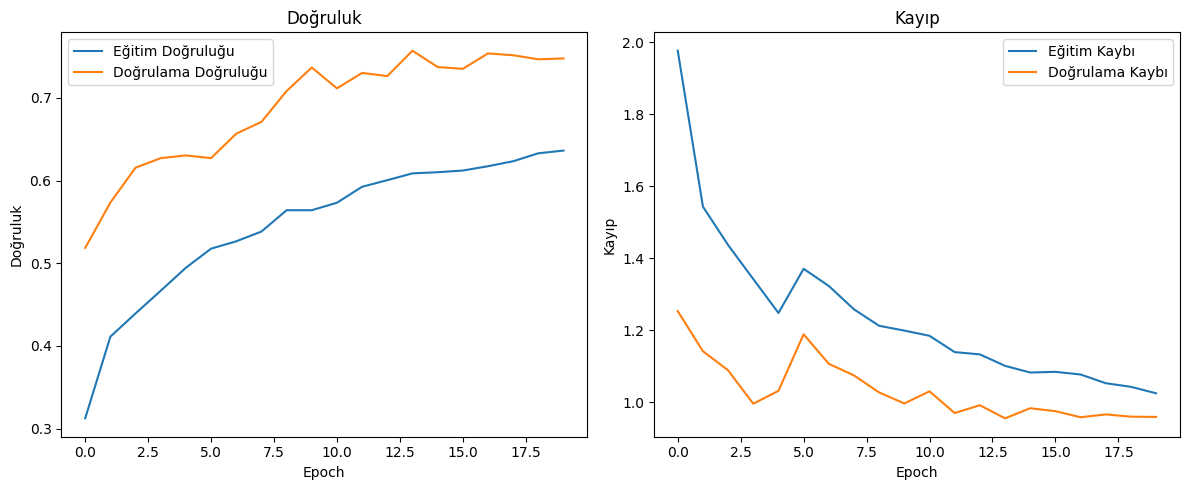

In [ ]:
with open("/content/drive/MyDrive/Defungi Classification/saved/history_vgg16.pkl", "rb") as f:
    history_dict = pickle.load(f)

acc = history_dict["accuracy"]
vall_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
vall_loss = history_dict["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label= "Eğitim Doğruluğu")
plt.plot(epochs_range, vall_acc, label= "Doğrulama Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.title("Doğruluk")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= "Eğitim Kaybı")
plt.plot(epochs_range, vall_loss, label= "Doğrulama Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Kayıp")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("/content/drive/MyDrive/Defungi Classification/saved/vgg16.h5")

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Defungi Classification/data/test",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

Found 1824 images belonging to 5 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_data.class_indices.keys())

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 502s 9s/step
Classification Report:
               precision    recall  f1-score   support

        BASH       0.64      0.44      0.52       467
         BBH       0.89      0.87      0.88       148
         GMA       0.71      0.77      0.74       164
         SHC       0.82      0.90      0.86       164
         TSH       0.77      0.88      0.82       881

    accuracy                           0.76      1824
   macro avg       0.77      0.77      0.77      1824
weighted avg       0.75      0.76      0.75      1824



57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step


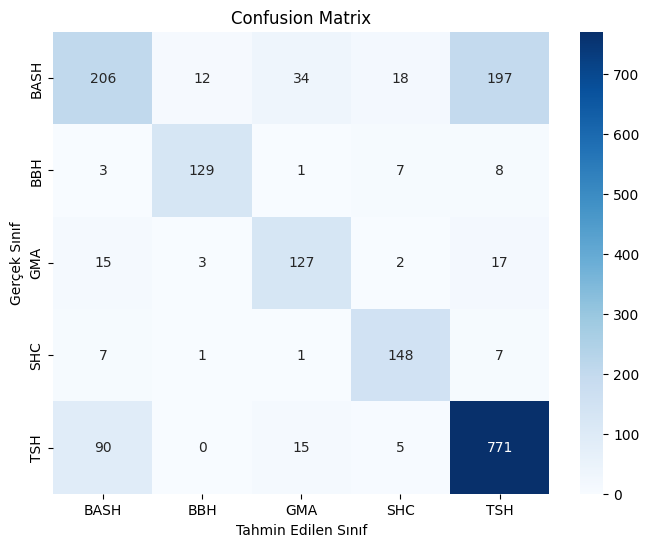

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2

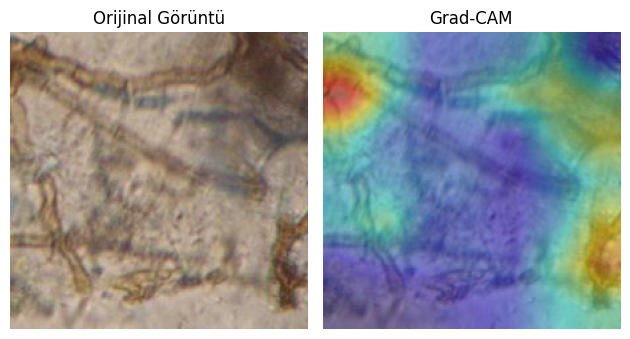

In [ ]:
img_path = "/content/drive/MyDrive/Defungi Classification/data/test/BBH/H6_10a_4.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

last_conv_layer_name = "block5_pool"

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]

grads = tape.gradient(class_channel, conv_outputs)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224, 224))

heatmap_np = np.array(heatmap)
heatmap_np = np.maximum(heatmap_np, 0)
heatmap_np /= np.max(heatmap_np)
heatmap_resized = cv2.resize(np.uint8(255 * heatmap_np), (img_orig.shape[1], img_orig.shape[0]))
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img_orig, 0.6, 0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Orijinal Görüntü")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.name)

#block5_pool